In [38]:
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECTS = ['calcite',
 'cayenne',
 'commons-bcel',
 'commons-beanutils',
 'commons-codec',
 'commons-collections',
 'commons-compress',
 'commons-configuration',
 'commons-dbcp',
 'commons-digester',
 'commons-imaging',
 'commons-io',
 'commons-jcs',
 'commons-jexl',
 'commons-lang',
 'commons-math',
 'commons-net',
 'commons-rdf',
 'commons-scxml',
 'commons-validator',
 'commons-vfs',
 'eagle',
 'falcon',
 'flume',
 'giraph',
 'gora',
 'jspwiki',
 'knox',
 'kylin',
 'lens',
 'mahout',
 'manifoldcf',
 'opennlp',
 'parquet-mr',
 'pdfbox',
 'phoenix',
 'ranger',
 'santuario-java',
 'storm',
 'struts',
 'systemml',
 'tez',
 'tika',
 'wss4j',
 'zeppelin',
 'helix',
  'httpcomponents-client', 'archiva', 'httpcomponents-core', 'jena', 'streams', 'mina-sshd', 'roller', 'nifi']
PROJECTS = sorted(PROJECTS)

TABLES_PATH = '../tables/'

from bson.objectid import ObjectId
from mongoengine import connect
from pycoshark.mongomodels import Project, VCSSystem, Commit, Tag, File, CodeEntityState, FileAction, People, IssueSystem, Issue, Message, MailingList, Event, MynbouData, Identity, Hunk, Branch
#loc = {'host': '127.0.0.1',
#       'port': 27017,
#       'db': 'smartshark',
#       'username': 'root',
#       'password': '',
#       'authentication_source': 'smartshark',
#       'connect': False}
#connect(**loc)
bimbes = {'host': '94.130.131.235',
       'port': 27017,
       'db': 'smartshark',
       'username': 'atrautsch',
       'password': 'balla',
       'authentication_source': 'smartshark',
       'connect': False}
connect(**bimbes)


def get_commit_message(revision_hash):
    c = Commit.objects.only('id', 'revision_hash', 'message', 'committer_date').get(revision_hash=revision_hash)
    return c

In [39]:
def yearly_usage(df):
    """Shortened version of the function in plots_tables.ipynb."""
    years = []

    for project_name in df['project'].unique():
        tmp2 = df[df['project'] == project_name]
        
        pr = {'project': project_name}
        for ye in df['year'].unique():
            tmp = df[(df['year'] == ye) & (df['project'] == project_name)]

            # we may not have this year for this project
            if len(tmp) == 0:
                continue
            
            yes_pmd = len(tmp[tmp['use_pmd'] == 1])
            no_pmd = len(tmp[tmp['use_pmd'] == 0])
            
            yes_checkstyle = len(tmp[tmp['use_checkstyle'] == 1])
            no_checkstyle = len(tmp[tmp['use_checkstyle'] == 0])

            yes_findbugs = len(tmp[tmp['use_findbugs'] == 1])
            no_findbugs = len(tmp[tmp['use_findbugs'] == 0])
            
            yes_maven = len(tmp[tmp['use_maven'] == 1])
            no_maven = len(tmp[tmp['use_maven'] == 0])

            pry = {'project': project_name, 
                   'year': ye, 
                   'complete_pmd': (yes_pmd > 0 and no_pmd == 0) or (yes_pmd == 0 and no_pmd > 1),
                   'complete_checkstyle': (yes_checkstyle > 0 and no_checkstyle == 0) or (yes_checkstyle == 0 and no_checkstyle > 1),
                   'complete_findbugs': (yes_findbugs > 0 and no_findbugs == 0) or (yes_findbugs == 0 and no_findbugs > 1),
                   'yes_pmd': yes_pmd, 
                   'no_pmd': no_pmd,
                   'yes_checkstyle': yes_checkstyle, 
                   'no_checkstyle': no_checkstyle,
                   'yes_findbugs': yes_findbugs, 
                   'no_findbugs': no_findbugs,
                   'yes_maven': yes_maven,
                   'no_maven': no_maven,
                   'use_maven': yes_maven > 0 and no_maven == 0}
            years.append(pry)
    return pd.DataFrame(years)

def merge_dd_data(dddf, years):
    tmp = years.copy()

    tmp['pmd_used'] = np.NaN
    tmp['pmd_not_used'] = np.NaN
    tmp['dd'] = np.NaN

    for project_name in years['project'].unique():
        for year in years[years['project'] == project_name]['year'].unique():
            dd = dddf[(dddf['project'] == project_name) & (dddf['year'] == year)]['issues_created'] / dddf[(dddf['project'] == project_name) & (dddf['year'] == year)]['code_klloc']
            fd = dddf[(dddf['project'] == project_name) & (dddf['year'] == year)]['issues_fixed'] / dddf[(dddf['project'] == project_name) & (dddf['year'] == year)]['effective_klloc']
            
            # this may not select anything
            if len(dd.values) > 0:
                tmp.loc[tmp[(tmp['project'] == project_name) & (tmp['year'] == year)].index, 'dd'] = dd.values[0]
                tmp.loc[tmp[(tmp['complete_pmd'] == True) & (tmp['yes_pmd'] > 0) & (tmp['project'] == project_name) & (tmp['year'] == year)].index, 'pmd_used'] = dd.values[0]
                tmp.loc[tmp[(tmp['complete_pmd'] == True) & (tmp['no_pmd'] > 0) & (tmp['project'] == project_name) & (tmp['year'] == year)].index, 'pmd_not_used'] = dd.values[0]
            
            #print(project_name, year, dd)
            
    fig = plt.figure()
    ax = tmp.boxplot(column=['pmd_used', 'pmd_not_used'])
    ax.set_xticklabels(['PMD', 'No PMD'])
    plt.show()

    yes_pmd = tmp[(tmp['complete_pmd'] == True) & (tmp['yes_pmd'] > 0)]['pmd_used'].values
    no_pmd = tmp[(tmp['complete_pmd'] == True) & (tmp['no_pmd'] > 0)]['pmd_not_used'].values

    yes_pmd = yes_pmd[~np.isnan(yes_pmd)]
    no_pmd = no_pmd[~np.isnan(no_pmd)]

    return tmp

def pmd_state_table():
    # load pmd state changes
    dfs = []
    for file in glob.glob('../data/*_pmd_states6.csv'):
        dfs.append(pd.read_csv(file))
    df = pd.concat(dfs, sort=False, ignore_index=True)

    # this is used to find the commit on which each ASAT was introduced or removed from the build configuration
    final_checkstyle = {}
    final_findbugs = {}
    final_spotbugs = {}
    final_pmd = {}

    for project_name in PROJECTS:
        checkstyle = {'introduced': [], 'removed': [], 'state': False}
        findbugs = {'introduced': [], 'removed': [], 'state': False}
        spotbugs = {'introduced': [], 'removed': [], 'state': False}
        pmd = {'introduced': [], 'removed': [], 'state': False}

        contains_project = False
        for var, name in [(checkstyle, 'use_checkstyle'), (findbugs, 'use_findbugs'), (spotbugs, 'use_spotbugs'), (pmd, 'use_pmd')]:
            for idx, row in df[(df['project'] == project_name)].iterrows():
                contains_project = True
                if row[name] != var['state']:
                    if row[name]:
                        var['introduced'].append(row['revision'])
                    else:
                        var['removed'].append(row['revision'])
                    var['state'] = row[name]


        if contains_project:
            del checkstyle['state']
            del findbugs['state']
            del spotbugs['state']
            del pmd['state']

            final_checkstyle[project_name] = checkstyle
            final_findbugs[project_name] = findbugs
            final_spotbugs[project_name] = spotbugs
            final_pmd[project_name] = pmd
        else:
            print('missing', project_name)

    # create table for commits where projects introduced or removed PMD from their buildfile includeing commit messages and date so that we can look at possible reasons
    rows = []
    for project, data in final_pmd.items():
        if not data:
            continue
        for i_rev in data['introduced']:
            c = get_commit_message(i_rev)
            msg = [] 
            for line in c.message.split('\n'):
                if not line.strip():
                    continue
                if line.strip().startswith('git-svn-id'):
                    continue
                msg.append(line)
            rows.append({'project': project, 'introduced': True, 'removed': False, 'date': c.committer_date, 'message': '\n'.join(msg), 'revision_hash': c.revision_hash})
        for r_rev in data['removed']:
            c = get_commit_message(r_rev)
            msg = [] 
            for line in c.message.split('\n'):
                if not line.strip():
                    continue
                if line.strip().startswith('git-svn-id'):
                    continue
                msg.append(line)
            rows.append({'project': project, 'introduced': False, 'removed': True, 'date': c.committer_date, 'message': '\n'.join(msg), 'revision_hash': c.revision_hash})
    df = pd.DataFrame(rows)
    return df

In [22]:
dfall = pd.read_pickle('../data/aggregated_full.pickle')
ddall = pd.read_csv('../data/defect_density.csv')
df_enriched = pd.read_pickle('../data/aggregated_full_enriched2.pickle')

print(ddall['project'].nunique(), 'projects')
print(ddall['project'].unique())
print(len(dfall))

54 projects
['archiva' 'calcite' 'cayenne' 'commons-bcel' 'commons-beanutils'
 'commons-codec' 'commons-collections' 'commons-compress'
 'commons-configuration' 'commons-dbcp' 'commons-digester'
 'commons-imaging' 'commons-io' 'commons-jcs' 'commons-jexl'
 'commons-lang' 'commons-math' 'commons-net' 'commons-rdf' 'commons-scxml'
 'commons-validator' 'commons-vfs' 'eagle' 'falcon' 'flume' 'giraph'
 'gora' 'helix' 'httpcomponents-client' 'httpcomponents-core' 'jena'
 'jspwiki' 'knox' 'kylin' 'lens' 'mahout' 'manifoldcf' 'mina-sshd' 'nifi'
 'opennlp' 'parquet-mr' 'pdfbox' 'phoenix' 'ranger' 'roller'
 'santuario-java' 'storm' 'streams' 'struts' 'systemml' 'tez' 'tika'
 'wss4j' 'zeppelin']
112267


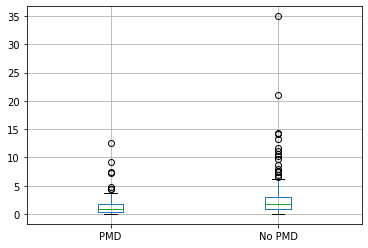

In [4]:
years = yearly_usage(dfall)
ret = merge_dd_data(ddall, years)

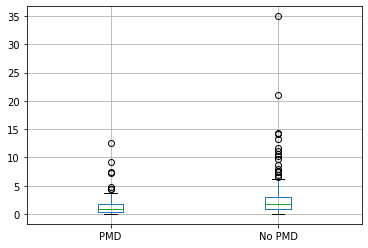

In [6]:
ret = merge_dd_data(ddall, years)

In [7]:
ret.head()

,project,year,complete_pmd,complete_checkstyle,complete_findbugs,yes_pmd,no_pmd,yes_checkstyle,no_checkstyle,yes_findbugs,no_findbugs,yes_maven,no_maven,use_maven,pmd_used,pmd_not_used,dd
0,archiva,2006,True,False,True,832,0,666,166,0,832,832,0,True,9.238072,NaN,9.238072
1,archiva,2007,True,True,False,766,0,766,0,176,590,766,0,True,12.636863,NaN,12.636863
2,archiva,2008,True,True,True,572,0,572,0,0,572,572,0,True,7.412962,NaN,7.412962
3,archiva,2009,True,True,True,142,0,142,0,0,142,142,0,True,4.769210,NaN,4.769210
4,archiva,2010,True,True,True,226,0,226,0,0,226,226,0,True,2.314378,NaN,2.314378


In [8]:
tmp1 = ret[(ret['complete_pmd'] == True) & (ret['yes_pmd'] > 0)].copy()
tmp2 = ret[(ret['complete_pmd'] == True) & (ret['no_pmd'] > 0)].copy()


#tmp1 = tmp1[['pmd_used', 'year']].groupby('year')

In [13]:
tmp2[['pmd_not_used', 'year']].groupby('year').count().reset_index()

,year,pmd_not_used
0,2001,0
1,2002,0
2,2003,1
3,2004,1
4,2005,3
5,2006,6
6,2007,13
7,2008,14
8,2009,17
9,2010,14


In [14]:
tmp1[['pmd_used', 'year']].groupby('year').count().reset_index()

,year,pmd_used
0,2006,1
1,2007,1
2,2008,5
3,2009,6
4,2010,9
5,2011,10
6,2012,12
7,2013,16
8,2014,15
9,2015,18


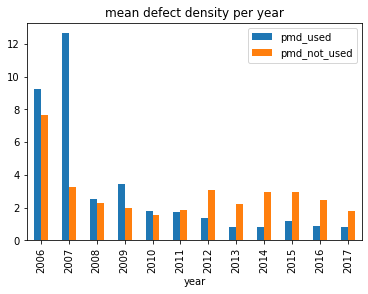

In [28]:
tmp1 = ret[(ret['complete_pmd'] == True) & (ret['yes_pmd'] > 0)].copy()
tmp2 = ret[(ret['complete_pmd'] == True) & (ret['no_pmd'] > 0)].copy()


tmp1 = tmp1[['pmd_used', 'year']].groupby('year').mean().reset_index()
tmp1.index = tmp1['year']

tmp2 = tmp2[['pmd_not_used', 'year']].groupby('year').mean().reset_index()
tmp2.index = tmp2['year']

meandf = tmp1.join(tmp2[['pmd_not_used']])
meandf[['pmd_used', 'pmd_not_used']].plot.bar(title='mean defect density per year')

In [36]:
dfall[dfall['revision'] == 'af0ddbcfc1e8c2528decbd458f42e16cbcae5051']

,revision,date,code_PMD_ABSALIL,code_PMD_ADLIBDC,code_PMD_AMUO,code_PMD_ATG,code_PMD_AUHCIP,code_PMD_AUOV,code_PMD_BII,code_PMD_BI,...,count_default_time,count_effective_time,minor_only_time,minor_only_time_ratio,major_only_time,major_only_time_ratio,critical_only_time,critical_only_time_ratio,year,use_maven


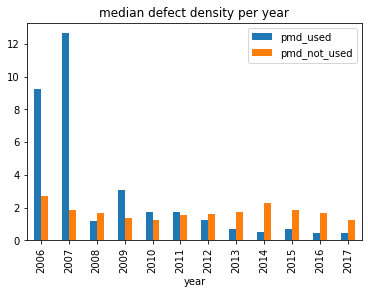

In [29]:
tmp1 = ret[(ret['complete_pmd'] == True) & (ret['yes_pmd'] > 0)].copy()
tmp2 = ret[(ret['complete_pmd'] == True) & (ret['no_pmd'] > 0)].copy()


tmp1 = tmp1[['pmd_used', 'year']].groupby('year').median().reset_index()
tmp1.index = tmp1['year']

tmp2 = tmp2[['pmd_not_used', 'year']].groupby('year').median().reset_index()
tmp2.index = tmp2['year']

mediandf = tmp1.join(tmp2[['pmd_not_used']])

mediandf[['pmd_used', 'pmd_not_used']].plot.bar(title='median defect density per year')

In [ ]:
# number of developers
# unique ids per year

In [52]:
# create the table containing addition / removal of pmd from the buildfile, add commit message from data enrichment
df = pmd_state_table()

In [41]:
df.head()

,project,introduced,removed,date,message,revision_hash
0,archiva,True,False,2005-11-28 04:50:31,update reports,af0ddbcfc1e8c2528decbd458f42e16cbcae5051
1,archiva,False,True,2012-09-25 11:19:32,use released parent,bf8deb5c1f75a00a53943b56b15354c9b9e01562
2,cayenne,True,False,2011-04-11 07:01:36,Fix all the poms for errors:\n* version number...,2589e30607864043e051ca09a625be4f0958520e
3,commons-bcel,True,False,2008-01-24 11:32:28,"compile tests with 1.5,\nfirst working maven s...",645828a22f42387309b55f4d08586e8a219f01b4
4,commons-bcel,True,False,2014-06-06 03:03:30,"Add more reports: FindBugs, PMD, Checkstyle.",d1fdb9a02cd23b8ff7df8e4436915fc4bf057092


In [77]:
df['date'] = pd.to_datetime(df['date'])

tmp = df.sort_values(['project', 'date'])
table = r'Project & C & Date & Reason\\' + '\n'
table += r'\hline' + '\n'

for idx, row in tmp.iterrows():
    rein = ' '
    if row['removed'] == True:
        rein = '-'
    elif row['introduced'] == True:
        rein = '+'
    reason = 'accident'
    table += r'{} & {} & {} & {}\\'.format(row['project'], rein, row['date'].date(), reason) + '\n'
print(table)

Project & C & Date & Reason\\
\hline
archiva & + & 2005-11-28 & accident\\
archiva & - & 2012-09-25 & accident\\
cayenne & + & 2011-04-11 & accident\\
commons-bcel & + & 2008-01-24 & accident\\
commons-bcel & - & 2008-02-05 & accident\\
commons-bcel & + & 2014-06-06 & accident\\
commons-beanutils & + & 2016-09-27 & accident\\
commons-codec & + & 2008-03-09 & accident\\
commons-collections & + & 2010-01-15 & accident\\
commons-compress & + & 2006-03-03 & accident\\
commons-compress & - & 2009-03-20 & accident\\
commons-compress & + & 2009-03-23 & accident\\
commons-dbcp & + & 2007-07-06 & accident\\
commons-dbcp & - & 2014-02-26 & accident\\
commons-dbcp & + & 2018-06-20 & accident\\
commons-digester & + & 2006-11-09 & accident\\
commons-imaging & + & 2012-04-19 & accident\\
commons-jcs & + & 2011-08-10 & accident\\
commons-jexl & + & 2007-11-17 & accident\\
commons-lang & + & 2009-05-16 & accident\\
commons-math & + & 2007-05-31 & accident\\
commons-math & - & 2009-07-29 & accident\\
c

In [81]:
df['date'] = pd.to_datetime(df['date'])

tmp = df.sort_values(['project', 'date'])
table = r'Project & C & Date & Message\\' + '\n'
table += r'\hline' + '\n'

for idx, row in tmp.iterrows():
    rein = ' '
    if row['removed'] == True:
        rein = '-'
    elif row['introduced'] == True:
        rein = '+'

    msg = row['message'].replace('_', '\_').split('\n')
    msg = r'. '.join(msg)
    table += r'{} & {} & {} & {}\\'.format(row['project'], rein, row['date'].date(), msg) + '\n'
print(table)

Project & C & Date & Message\\
\hline
archiva & + & 2005-11-28 & update reports\\
archiva & - & 2012-09-25 & use released parent\\
cayenne & + & 2011-04-11 & Fix all the poms for errors:. * version numbers not provided for maven plugins. * inheritance from child poms to parent broken (this should fix the requirement to 'mvn install' before building)\\
commons-bcel & + & 2008-01-24 & compile tests with 1.5,. first working maven site,. integrated the xdoc\\
commons-bcel & - & 2008-02-05 & added OSGi meta data. http://issues.apache.org/bugzilla/show\_bug.cgi?id=44359\\
commons-bcel & + & 2014-06-06 & Add more reports: FindBugs, PMD, Checkstyle.\\
commons-beanutils & + & 2016-09-27 & enable pmd and findbugs reports. .. newer japicmp and clirr to work with Java 8\\
commons-codec & + & 2008-03-09 & Specify report plugin versions and add cobertura, pmd and findbugs reports (as per m1 build)\\
commons-collections & + & 2010-01-15 & Adding PMD report and missing license header\\
commons-compres

In [65]:
df['date'].dt.date

0     2005-11-28
1     2012-09-25
2     2011-04-11
3     2008-01-24
4     2014-06-06
5     2008-02-05
6     2016-09-27
7     2008-03-09
8     2010-01-15
9     2006-03-03
10    2009-03-23
11    2009-03-20
12    2007-07-06
13    2018-06-20
14    2014-02-26
15    2006-11-09
16    2012-04-19
17    2011-08-10
18    2007-11-17
19    2009-05-16
20    2007-05-31
21    2009-08-15
22    2011-07-27
23    2009-07-29
24    2010-03-23
25    2016-09-09
26    2007-01-07
27    2014-12-26
28    2008-01-10
29    2012-02-16
30    2012-05-14
31    2009-07-16
32    2017-05-17
33    2016-01-26
34    2012-06-28
35    2014-03-05
36    2008-09-19
37    2010-08-05
38    2009-03-03
Name: date, dtype: object

{'archiva': {'introduced': ['af0ddbcfc1e8c2528decbd458f42e16cbcae5051'],
  'removed': ['bf8deb5c1f75a00a53943b56b15354c9b9e01562']},
 'calcite': {'introduced': [], 'removed': []},
 'cayenne': {'introduced': ['2589e30607864043e051ca09a625be4f0958520e'],
  'removed': []},
 'commons-bcel': {'introduced': ['645828a22f42387309b55f4d08586e8a219f01b4',
   'd1fdb9a02cd23b8ff7df8e4436915fc4bf057092'],
  'removed': ['ff6317ed4e2c76bffdfbaa9e836e7ae328bb3b74']},
 'commons-beanutils': {'introduced': ['247bcdd1edc18179844bc87b0843910e427421ba'],
  'removed': []},
 'commons-codec': {'introduced': ['40e7a6abc4e42ef55cd40705f5cf24addd1c0824'],
  'removed': []},
 'commons-collections': {'introduced': ['96925c7a40b83c7cd17fd9bedac43181c7a79d12'],
  'removed': []},
 'commons-compress': {'introduced': ['7c222cdcff63f23f3921e1915d73bb4918263f8b',
   'f03f2f969376c36a344f8486d94672624c78accd'],
  'removed': ['01185cb7374a070a318f6780f7637b498be8394e']},
 'commons-configuration': {'introduced': [], 'removed'

In [17]:
# popularity, collected on 2020-05-04
pop = {'archiva': {'stars': 257, 'forks': 103},
       'calcite': {'stars': 1821, 'forks': 1100},
       'cayenne': {'stars': 215, 'forks': 100},
       'commons-bcel': {'stars': 117, 'forks': 78},
       'commons-beanutils': {'stars': 168, 'forks': 128},
       'commons-codec': {'stars': 248, 'forks': 164},
       'commons-collections': {'stars': 415, 'forks': 285},
       'commons-compress': {'stars': 144, 'forks': 153},
       'commons-configuration': {'stars': 102, 'forks': 96},
       'commons-dbcp': {'stars': 226, 'forks': 170},
       'commons-digester': {'stars': 28, 'forks': 30},
       'commons-imaging': {'stars': 205, 'forks': 114},
       'commons-io': {'stars': 676, 'forks': 440},
       'commons-jcs': {'stars': 65, 'forks': 36},
       'commons-jexl': {'stars': 69, 'forks': 46},
       'commons-lang': {'stars': 1889, 'forks': 1200},
       'commons-math': {'stars': 327, 'forks': 258},
       'commons-net': {'stars': 121, 'forks': 110},
       'commons-rdf': {'stars': 25, 'forks': 37},
       'commons-scxml': {'stars': 40, 'forks': 33},
       'commons-validator': {'stars': 111, 'forks': 95},
       'commons-vfs': {'stars': 108, 'forks': 133},
       'eagle': {'stars': 394, 'forks': 191},
       'falcon': {'stars': 95, 'forks': 111},
       'flume': {'stars': 1937, 'forks': 1400},
       'giraph': {'stars': 546, 'forks': 285},
       'gora': {'stars': 94, 'forks': 101},
       'helix': {'stars': 253, 'forks': 140},
       'httpcomonents-client': {'stars': 930, 'forks': 655},
       'httpcomonents-core': {'stars': 207, 'forks': 222},
       'jena': {'stars': 634, 'forks': 480},
       'jspwiki': {'stars': 66, 'forks': 65},
       'knox': {'stars': 98, 'forks': 157},
       'kylin': {'stars': 2625, 'forks': 1200},
       'lens': {'stars': 57, 'forks': 97},
       'mahout': {'stars': 1821, 'forks': 942},
       'manifoldcf': {'stars': 64, 'forks': 53},
       'mina-sshd': {'stars': 257, 'forks': 174},
       'nifi': {'stars': 2022, 'forks': 1700},
       'opennlp': {'stars': 930, 'forks': 364},
       'parquet-mr': {'stars': 1070, 'forks': 936},
       'pdfbox': {'stars': 1133, 'forks': 487},
       'phoenix': {'stars': 787, 'forks': 829},
       'ranger': {'stars': 360, 'forks': 346},
       'roller': {'stars': 87, 'forks': 100},
       'santuario-java': {'stars': 22, 'forks': 38},
       'storm': {'stars': 6068, 'forks': 4100},
       'streams': {'stars': 65, 'forks': 38},
       'struts': {'stars': 1005, 'forks': 666},
       'systemml': {'stars': 812, 'forks': 329},
       'tez': {'stars': 268, 'forks': 263},
       'tika': {'stars': 963, 'forks': 544},
       'wss4j': {'stars': 5, 'forks': 7},
       'zeppelin': {'stars': 4675, 'forks': 2300},
      }

In [83]:
ddall[['project', 'issues_created', 'issues_fixed']].groupby('project').sum()

,issues_created,issues_fixed
project,,
archiva,1109,427
calcite,1123,719
cayenne,723,371
commons-bcel,77,48
commons-beanutils,144,64
commons-codec,91,67
commons-collections,183,117
commons-compress,187,147
commons-configuration,261,160


In [91]:
years = []
for project_name in PROJECTS:
    p = Project.objects.get(name=project_name)
    print(project_name)
    
    its = IssueSystem.objects.get(project_id=p.id)
    first = Issue.objects.filter(issue_system_id=its.id, created_at__exists=True).order_by('created_at').limit(1)[0]
    last = Issue.objects.filter(issue_system_id=its.id, created_at__exists=True).order_by('-created_at').limit(1)[0]
    
    print('issue range', (last.created_at - first.created_at).days / 365)
    years.append((last.created_at - first.created_at).days / 365)

    
print('avg', np.mean(years), 'median', np.median(years))

archiva
issue range 14.035616438356165
calcite
issue range 4.041095890410959
cayenne
issue range 14.610958904109589
commons-bcel
issue range 16.895890410958906
commons-beanutils
issue range 17.016438356164382
commons-codec
issue range 16.457534246575342
commons-collections
issue range 17.482191780821918
commons-compress
issue range 14.282191780821918
commons-configuration
issue range 15.805479452054794
commons-dbcp
issue range 17.104109589041094
commons-digester
issue range 17.734246575342464
commons-imaging
issue range 10.668493150684931
commons-io
issue range 15.561643835616438
commons-jcs
issue range 12.068493150684931
commons-jexl
issue range 15.36986301369863
commons-lang
issue range 16.328767123287673
commons-math
issue range 14.767123287671232
commons-net
issue range 16.673972602739727
commons-rdf
issue range 3.33972602739726
commons-scxml
issue range 12.761643835616438
commons-validator
issue range 16.5972602739726
commons-vfs
issue range 14.682191780821919
eagle
issue range 2.